In [38]:
import os
import re
import pandas as pd
import numpy as np
import sys
import glob
import traceback
import datetime
import json
import folium

sys.path.append('/lib')
sys.path.append('/data')
import lib.helper as helper

%matplotlib inline
%load_ext folium_magic

WORKSHOP_TYPES = ["SWC", "DC", "LC", "TTT"]
STOPPED_WORKSHOP_TYPES = ['stalled', 'cancelled', 'unresponsive']

CURRENT_DIR = os.getcwd()
DATA_DIR = CURRENT_DIR + '/data'
RAW_DATA_DIR = DATA_DIR + '/raw'
PROCESSED_DATA_DIR = DATA_DIR + '/processed'
MAPS_DIR = DATA_DIR + "/maps"
UK_REGIONS_FILE = CURRENT_DIR + '/lib/UK-regions.json'

The folium_magic extension is already loaded. To reload it, use:
  %reload_ext folium_magic


In [2]:
import sys
!{sys.executable} -m pip show folium

Name: folium
Version: 0.10.1
Summary: Make beautiful maps with Leaflet.js & Python
Home-page: https://github.com/python-visualization/folium
Author: Rob Story
Author-email: wrobstory@gmail.com
License: MIT
Location: /Users/alex/anaconda/lib/python3.6/site-packages
Requires: requests, jinja2, numpy, branca
Required-by: ipython-magic-folium


In [3]:
# Absolute or relative path to workshop data extracted from Carpentries Redash
workshops_file = RAW_DATA_DIR + "/redash_UK_workshops_2020_03_11.csv"
workshops_df = pd.read_csv(workshops_file, encoding="utf-8")

In [4]:
# Convert column "tags" from a string to a list of strings
idx = workshops_df.columns.get_loc("tags")
workshops_df.insert(loc=idx, column='tags_list', value=workshops_df["tags"])
workshops_df["tags_list"] = workshops_df["tags"].str.split(',')

In [5]:
# Check we indeed have created a list of tags
workshops_df.tags_list[4]

['Circuits']

In [6]:
# Extract workshop type ('SWC', 'DC', 'LC', 'Circuits', 'TTT') and status ('cancelled', 'unresponsive', 'stalled', "Pilot") 
# and add as a new column
idx = workshops_df.columns.get_loc("tags_list")
workshops_df.insert(loc=idx, column='workshop_type',
                            value=workshops_df["tags_list"])
workshops_df["workshop_type"] = workshops_df["tags_list"].map(helper.extract_workshop_type, na_action="ignore")
workshops_df

,slug,venue,address,country_code,longitude,latitude,start,end,attendance,organiser,organiser_domain,organiser_country_code,workshop_type,tags_list,tags,workshop_request_domains,event_request_id
0,2020-05-20-swansea,"Singleton Campus, Swansea University","Room 516, Vivian Tower, Swansea University, Si...",GB,-3.982323,51.609054,2020-05-20,2020-05-21,0,Swansea University,swansea.ac.uk,GB,SWC,[SWC],SWC,NaN,NaN
1,2020-03-03-earlham,Earlham Institute,"Norwich Research Park, Norwich, NR4 7UZ UK",GB,1.218976,52.621887,2020-03-03,2020-03-04,0,Earlham Institute,earlham.ac.uk,GB,DC,[DC],DC,NaN,NaN
2,2020-02-25-cardiff,Cardiff,"Mercure Hotel, Newport Road, Cardiff",GB,-3.167152,51.483926,2020-02-25,2020-02-26,0,Swansea University,swansea.ac.uk,GB,SWC,[SWC],SWC,NaN,NaN
3,2020-02-25-KRAKOW-TEST,Manchester University,NaN,GB,NaN,NaN,2020-02-25,2020-02-26,0,Cyfronet,cyfronet.pl,PL,LC,"[LC, automated-email]","LC,automated-email",NaN,NaN
4,2020-02-20-lancaster,Lancaster University,"Bowland Hall, Bailrigg, Lancaster LA1 4ZA",GB,-2.789279,54.012121,2020-02-21,2020-02-22,0,CCP CoDiMa,codima.ac.uk,GB,,[Circuits],Circuits,NaN,NaN
5,2020-02-18-UCL,UCL,"G20 Christopher Ingold Public Cluster, Christo...",GB,-0.132152,51.525388,2020-02-18,2020-02-19,0,University College London,ucl.ac.uk,GB,SWC,[SWC],SWC,NaN,NaN
6,2020-02-12-edinburgh,"Room 4.2, Lister Building","5 Roxburgh Pl, Edinburgh EH8 9SU",GB,-3.184209,55.947159,2020-02-12,2020-03-04,0,University of Edinburgh,ed.ac.uk,GB,DC,[DC],DC,NaN,NaN
7,2020-02-10-turing,"Software Carpentry Workshop, The Alan Turing I...","British Library, 96 Euston Road, London, NW1 2DB",GB,-0.127100,51.530200,2020-02-10,2020-02-11,0,Alan Turing Institute,turing.ac.uk,GB,SWC,[SWC],SWC,NaN,NaN
8,2020-01-29-edinburgh,University of Edinburgh,"Computer Lab, Room 2.02, Old Infirmary Buildin...",GB,-3.185788,55.947331,2020-01-29,2020-01-30,0,University of Edinburgh,ed.ac.uk,GB,SWC,[SWC],SWC,NaN,NaN
9,2020-01-21-earlham,Earlham Institute,"Norwich Research Park, Norwich, NR4 7UZ UK",GB,1.218976,52.621887,2020-01-21,2020-01-22,0,Earlham Institute,earlham.ac.uk,GB,SWC,[SWC],SWC,NaN,NaN


In [7]:
# How many workshops that do not have a workshop type?
print(workshops_df[workshops_df['workshop_type']==""][["slug", "tags_list"]])
print(workshops_df[workshops_df['workshop_type']==""]['workshop_type'].count())

                                       slug        tags_list
4                      2020-02-20-lancaster       [Circuits]
17                        2019-12-11-durham       [Circuits]
20                   2019-11-19-aberystwyth       [Circuits]
21               2019-11-19-southampton-swc       [Circuits]
23   2019-11-15-edinburgh-library-carpentry       [Circuits]
26                   2019-11-06-aberystwyth       [Circuits]
36                     2019-10-07-unixshell       [Circuits]
80                        2019-03-19-oxford      [cancelled]
120                       2018-10-17-oxford      [cancelled]
124                           2018-10-02-DC      [cancelled]
132                       2018-09-05-dundee      [cancelled]
164                         2018-01-xx-bath        [stalled]
196                       2017-07-12-sussex  [WiSE, stalled]
205                       2017-04-27-london      [cancelled]
215                       2017-02-13-oxford      [cancelled]
226                     

In [8]:
# Extract 'stopped' workshop status, normally ('cancelled', 'unresponsive', 'stalled'), and separate from the workshop's type
idx = workshops_df.columns.get_loc("tags_list")
workshops_df.insert(loc=idx, column='workshop_status',
                            value=workshops_df["tags_list"])
workshops_df["workshop_status"] = workshops_df["tags_list"].map(helper.extract_workshop_status, na_action="ignore")

In [9]:
# How many workshops that do not have a status?
print(workshops_df[workshops_df['workshop_status']==""][["slug", "workshop_type", "tags"]])
print(workshops_df[workshops_df['workshop_status']==""]['workshop_status'].count())

print("Total workshops: " + str(len(workshops_df.index)))

                                       slug workshop_type                tags
0                        2020-05-20-swansea           SWC                 SWC
1                        2020-03-03-earlham            DC                  DC
2                        2020-02-25-cardiff           SWC                 SWC
3                    2020-02-25-KRAKOW-TEST            LC  LC,automated-email
4                      2020-02-20-lancaster                          Circuits
5                            2020-02-18-UCL           SWC                 SWC
6                      2020-02-12-edinburgh            DC                  DC
7                         2020-02-10-turing           SWC                 SWC
8                      2020-01-29-edinburgh           SWC                 SWC
9                        2020-01-21-earlham           SWC                 SWC
10                 2020-01-21-edinburgh-swc           SWC                 SWC
11             2020-01-15-ukaea-swcarpentry           SWC       

In [10]:
# How many "stopped" workshops are there?
workshops_df[(workshops_df['workshop_status'].isin(STOPPED_WORKSHOP_TYPES))]['workshop_status'].value_counts()

cancelled       13
stalled         13
unresponsive     5
Name: workshop_status, dtype: int64

In [11]:
# How many "Circuits" workshops are there?
workshops_df[workshops_df['workshop_type'] == 'Circuits']

,slug,venue,address,country_code,longitude,latitude,start,end,attendance,organiser,organiser_domain,organiser_country_code,workshop_type,workshop_status,tags_list,tags,workshop_request_domains,event_request_id


In [12]:
# Insert countries where workshops were held based on country_code
idx = workshops_df.columns.get_loc("country_code")
workshops_df.insert(loc=idx + 1, column='country',
                            value=workshops_df["country_code"])
# workshops_df["country"] = workshops_df["country_code"].map(helper.get_country, na_action="ignore")
# workshops_df

countries = pd.read_csv("lib/country_codes.csv", encoding = "utf-8", keep_default_na = False) # keep_default_na prevents Namibia "NA" being read as NaN!
countries_mapping = dict(countries[['country_code', 'country_name']].values)
print(countries_mapping)
workshops_df['country'] = workshops_df['country_code'].map(countries_mapping, na_action="ignore")
workshops_df.head

{'AF': 'Afghanistan', 'AX': 'Ã…land Islands', 'AL': 'Albania', 'DZ': 'Algeria', 'AS': 'American Samoa', 'AD': 'Andorra', 'AO': 'Angola', 'AI': 'Anguilla', 'AQ': 'Antarctica', 'AG': 'Antigua and Barbuda', 'AR': 'Argentina', 'AM': 'Armenia', 'AW': 'Aruba', 'AU': 'Australia', 'AT': 'Austria', 'AZ': 'Azerbaijan', 'BS': 'Bahamas', 'BH': 'Bahrain', 'BD': 'Bangladesh', 'BB': 'Barbados', 'BY': 'Belarus', 'BE': 'Belgium', 'BZ': 'Belize', 'BJ': 'Benin', 'BM': 'Bermuda', 'BT': 'Bhutan', 'BO': 'Bolivia, Plurinational State of', 'BQ': 'Bonaire, Sint Eustatius and Saba', 'BA': 'Bosnia and Herzegovina', 'BW': 'Botswana', 'BV': 'Bouvet Island', 'BR': 'Brazil', 'IO': 'British Indian Ocean Territory', 'BN': 'Brunei Darussalam', 'BG': 'Bulgaria', 'BF': 'Burkina Faso', 'BI': 'Burundi', 'KH': 'Cambodia', 'CM': 'Cameroon', 'CA': 'Canada', 'CV': 'Cape Verde', 'KY': 'Cayman Islands', 'CF': 'Central African Republic', 'TD': 'Chad', 'CL': 'Chile', 'CN': 'China', 'CX': 'Christmas Island', 'CC': 'Cocos (Keeling) 

<bound method NDFrame.head of                                        slug  \
0                        2020-05-20-swansea   
1                        2020-03-03-earlham   
2                        2020-02-25-cardiff   
3                    2020-02-25-KRAKOW-TEST   
4                      2020-02-20-lancaster   
5                            2020-02-18-UCL   
6                      2020-02-12-edinburgh   
7                         2020-02-10-turing   
8                      2020-01-29-edinburgh   
9                        2020-01-21-earlham   
10                 2020-01-21-edinburgh-swc   
11             2020-01-15-ukaea-swcarpentry   
12                           2020-01-09-kcl   
13                       2020-01-08-swansea   
14                    2019-12-16-london-kcl   
15               2019-12-16-southampton-swc   
16                    2019-12-12-Manchester   
17                        2019-12-11-durham   
18                       2019-12-04-swansea   
19                     2019-11

In [13]:
# How many workshops are not from the UK?
print(workshops_df[workshops_df['country_code'] != "GB"])
# How many workshops are missing country information?
workshops_df[workshops_df['country_code'].isnull()]

                                         slug  \
31                            2019-10-16-UCLQ   
46                   2019-07-01-elixir-sib-dc   
51                      2019-06-06-elixir-bsc   
53               2019-06-03-elixir-athens-eie   
56                 2019-05-30-elixir-portugal   
60                 2018-05-16-elixir-slovenia   
63                           2019-05-13-Ghent   
69                         2019-04-25-rosario   
71                             2019-04-16-BRU   
75            2019-04-01-ELIXIR-NORWAY_BERGEN   
76                       2019-04-01-elxir-csc   
79                   2019-04-15-elixir-france   
80                          2019-03-19-oxford   
87                   2019-02-14-elixir-milano   
88                   2018-02-14-elixir-prague   
89               2019-02-14-elixir-luxembourg   
90                          2019-02-11-Naples   
93                             2019-02-06-SZN   
94                2019-01-29-elixir-Ljubljana   
100                 

,slug,venue,address,country_code,country,longitude,latitude,start,end,attendance,organiser,organiser_domain,organiser_country_code,workshop_type,workshop_status,tags_list,tags,workshop_request_domains,event_request_id
89,2019-02-14-elixir-luxembourg,NaN,NaN,NaN,NaN,NaN,NaN,2019-02-11,2019-02-15,0,ELIXIR-UK,elixir-uk.org,GB,SWC,cancelled,"[SWC, cancelled]","SWC,cancelled",NaN,NaN
105,2018-12-03-elixir-netherlands,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-03,2018-12-07,0,ELIXIR-UK,elixir-uk.org,GB,DC,cancelled,"[DC, cancelled]","DC,cancelled",NaN,NaN
120,2018-10-17-oxford,NaN,NaN,NaN,NaN,NaN,NaN,2018-10-17,2018-10-18,0,University of Oxford,ox.ac.uk,GB,,cancelled,[cancelled],cancelled,"High performance computing:Genetics, genomics,...",536.0
196,2017-07-12-sussex,NaN,NaN,NaN,NaN,NaN,NaN,2017-07-12,2017-07-12,0,University of Sussex,sussex.ac.uk,GB,,stalled,"[WiSE, stalled]","WiSE,stalled",NaN,NaN
341,2017-01-xx-oxford,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,First Light Fusion,firstlightfusion.com,GB,SWC,stalled,"[SWC, stalled]","SWC,stalled",Physics,178.0
349,2018-12-xx-sussex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,University of Sussex,sussex.ac.uk,GB,SWC,stalled,"[SWC, stalled]","SWC,stalled",Don't know yet,561.0


Total workshops organised by the UK in other countries: 26
                                         slug         country
31                            2019-10-16-UCLQ           Qatar
46                   2019-07-01-elixir-sib-dc     Switzerland
51                      2019-06-06-elixir-bsc           Spain
53               2019-06-03-elixir-athens-eie          Greece
56                 2019-05-30-elixir-portugal        Portugal
60                 2018-05-16-elixir-slovenia        Slovenia
63                           2019-05-13-Ghent         Belgium
69                         2019-04-25-rosario         Finland
71                             2019-04-16-BRU         Belgium
75            2019-04-01-ELIXIR-NORWAY_BERGEN          Norway
76                       2019-04-01-elxir-csc         Finland
79                   2019-04-15-elixir-france          France
80                          2019-03-19-oxford   United States
87                   2019-02-14-elixir-milano           Italy
88         

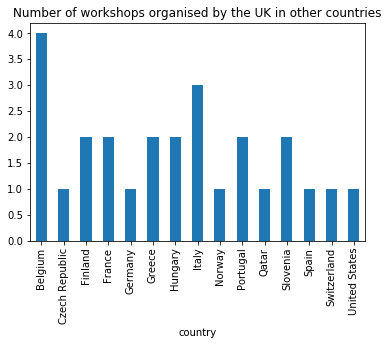

In [14]:
# How many workshops organised by UK institutions but outside of UK?
print("Total workshops organised by the UK in other countries: " + 
      str(workshops_df[workshops_df['country_code'] != "GB"]['country_code'].count()))
workshops_outside_UK = workshops_df[workshops_df['country_code'] != "GB"]
print(workshops_outside_UK[['slug', 'country']])

workshops_outside_UK_per_country = workshops_outside_UK.groupby(['country'])['country'].count()
workshops_outside_UK_per_country.plot(kind='bar', stacked=True, title="Number of workshops organised by the UK in other countries")
print(workshops_outside_UK_per_country)

In [15]:
# Add UK region for a workshop based on its geocoordinates as a new column
idx = workshops_df.columns.get_loc("country")
workshops_df.insert(loc=idx + 1, column='region',
                            value=workshops_df["country_code"])
workshops_df['region'] = workshops_df.apply(lambda x: helper.get_uk_region(latitude=x['latitude'],
                                    longitude=x['longitude']), axis=1)
print("\n################################\nThis took a while but it has finished now")

Looking up region for geocoordinates: (51.609054, -3.9823230000000005)
Looking up region for geocoordinates: (52.621887, 1.218976)
Looking up region for geocoordinates: (51.483926000000004, -3.167152)
Looking up region for geocoordinates: (nan, nan)
Could no find UK region for location (nan, nan)
Looking up region for geocoordinates: (54.01212099999999, -2.789279)
Looking up region for geocoordinates: (51.525388, -0.132152)
Looking up region for geocoordinates: (55.947159, -3.184209)
Looking up region for geocoordinates: (51.5302, -0.1271)
Looking up region for geocoordinates: (55.947331000000005, -3.185788)
Looking up region for geocoordinates: (52.621887, 1.218976)
Looking up region for geocoordinates: (55.924386, -3.179406)
Looking up region for geocoordinates: (51.657, -1.23)
Looking up region for geocoordinates: (51.513115, -0.11556)
Looking up region for geocoordinates: (51.617903000000005, -3.880897)
Looking up region for geocoordinates: (51.511590000000005, -0.11896)
Looking up

In [16]:
# Add UK region for a workshop based on its organiser (lookup UK academic institutitons and HESA data) as a new column
uk_academic_institutions = pd.read_csv("lib/UK-academic-institutions.csv", encoding = "utf-8")
hesa_UK_higher_education_providers = pd.read_csv("lib/HESA_UK_higher_education_providers.csv", encoding = "utf-8")
hesa_UK_higher_education_providers_region_mapping = dict(hesa_UK_higher_education_providers[['UKPRN', 'Region']].values) # create a dict for lookup

uk_academic_institutions['domain'] = uk_academic_institutions['WEBSITE_URL'].apply(lambda x: x.strip("http://www.").strip("/")) # strip 'http://www' from domain
uk_academic_institutions['region'] = uk_academic_institutions['UKPRN'].map(hesa_UK_higher_education_providers_region_mapping, na_action="ignore")
print(uk_academic_institutions)

uk_academic_institutions_region_mapping = dict(uk_academic_institutions[['domain', 'region']].values) # create a dict for lookup

idx = workshops_df.columns.get_loc("organiser_country_code")
workshops_df.insert(loc=idx + 1, column='organiser_region', value=workshops_df["organiser_domain"])
workshops_df['organiser_region'] = workshops_df['organiser_region'].map(uk_academic_institutions_region_mapping,na_action="ignore")
workshops_df.head(5)

        UKPRN                                      PROVIDER_NAME  \
0    10008640                                FALMOUTH UNIVERSITY   
1    10007774                               UNIVERSITY OF OXFORD   
2    10007768                            UNIVERSITY OF LANCASTER   
3    10000571                                BATH SPA UNIVERSITY   
4    10007814                                 CARDIFF UNIVERSITY   
5    10007158                          UNIVERSITY OF SOUTHAMPTON   
6    10007779                       THE ROYAL VETERINARY COLLEGE   
7    10007851                                UNIVERSITY OF DERBY   
8    10000824                             BOURNEMOUTH UNIVERSITY   
9    10007162                     UNIVERSITY OF THE ARTS, LONDON   
10   10007804                             UNIVERSITY OF STIRLING   
11   10007823                               EDGE HILL UNIVERSITY   
12   10007160                               UNIVERSITY OF SURREY   
13   10007791                                UNI

,slug,venue,address,country_code,country,region,longitude,latitude,start,end,...,organiser,organiser_domain,organiser_country_code,organiser_region,workshop_type,workshop_status,tags_list,tags,workshop_request_domains,event_request_id
0,2020-05-20-swansea,"Singleton Campus, Swansea University","Room 516, Vivian Tower, Swansea University, Si...",GB,United Kingdom,Wales,-3.982323,51.609054,2020-05-20,2020-05-21,...,Swansea University,swansea.ac.uk,GB,NaN,SWC,,[SWC],SWC,NaN,NaN
1,2020-03-03-earlham,Earlham Institute,"Norwich Research Park, Norwich, NR4 7UZ UK",GB,United Kingdom,Eastern,1.218976,52.621887,2020-03-03,2020-03-04,...,Earlham Institute,earlham.ac.uk,GB,NaN,DC,,[DC],DC,NaN,NaN
2,2020-02-25-cardiff,Cardiff,"Mercure Hotel, Newport Road, Cardiff",GB,United Kingdom,Wales,-3.167152,51.483926,2020-02-25,2020-02-26,...,Swansea University,swansea.ac.uk,GB,NaN,SWC,,[SWC],SWC,NaN,NaN
3,2020-02-25-KRAKOW-TEST,Manchester University,NaN,GB,United Kingdom,None,NaN,NaN,2020-02-25,2020-02-26,...,Cyfronet,cyfronet.pl,PL,NaN,LC,,"[LC, automated-email]","LC,automated-email",NaN,NaN
4,2020-02-20-lancaster,Lancaster University,"Bowland Hall, Bailrigg, Lancaster LA1 4ZA",GB,United Kingdom,North West,-2.789279,54.012121,2020-02-21,2020-02-22,...,CCP CoDiMa,codima.ac.uk,GB,NaN,,,[Circuits],Circuits,NaN,NaN


In [17]:
print(workshops_df.columns)
workshops_df[workshops_df['region'].isnull()]

Index(['slug', 'venue', 'address', 'country_code', 'country', 'region',
       'longitude', 'latitude', 'start', 'end', 'attendance', 'organiser',
       'organiser_domain', 'organiser_country_code', 'organiser_region',
       'workshop_type', 'workshop_status', 'tags_list', 'tags',
       'workshop_request_domains', 'event_request_id'],
      dtype='object')


,slug,venue,address,country_code,country,region,longitude,latitude,start,end,...,organiser,organiser_domain,organiser_country_code,organiser_region,workshop_type,workshop_status,tags_list,tags,workshop_request_domains,event_request_id
3,2020-02-25-KRAKOW-TEST,Manchester University,NaN,GB,United Kingdom,None,NaN,NaN,2020-02-25,2020-02-26,...,Cyfronet,cyfronet.pl,PL,NaN,LC,,"[LC, automated-email]","LC,automated-email",NaN,NaN
15,2019-12-16-southampton-swc,"B32/3077, Highfield Campus",NaN,GB,United Kingdom,None,NaN,NaN,2019-12-16,2019-12-17,...,University of Southampton,southampton.ac.uk,GB,NaN,SWC,,[SWC],SWC,NaN,NaN
31,2019-10-16-UCLQ,UCL Qatar,"Room 2B01, UCL Qatar Library, Humanitarium, Ed...",QA,Qatar,None,51.444066,25.318391,2019-10-16,2019-10-17,...,University College London,ucl.ac.uk,GB,London,LC,,[LC],LC,NaN,NaN
42,2019-09-30-Manchester,NaN,NaN,GB,United Kingdom,None,NaN,NaN,2019-08-30,2019-08-31,...,University of Manchester,manchester.ac.uk,GB,North West,DC,,[DC],DC,NaN,NaN
46,2019-07-01-elixir-sib-dc,NaN,NaN,CH,Switzerland,None,NaN,NaN,2019-07-01,2019-07-02,...,ELIXIR-UK,elixir-uk.org,GB,NaN,DC,,[DC],DC,NaN,NaN
51,2019-06-06-elixir-bsc,Elixir-CNIO,"Melchor Fernández Almagro, 3. 28029 Madrid",ES,Spain,None,-3.696091,40.476688,2019-06-06,2019-06-07,...,ELIXIR-UK,elixir-uk.org,GB,NaN,SWC,,[SWC],SWC,NaN,NaN
53,2019-06-03-elixir-athens-eie,National Hellenic Research Foundation,"48 Leoforos Vasileos Konstantinou, 116 35 Athe...",GR,Greece,None,23.745407,37.973198,2019-06-03,2019-06-04,...,ELIXIR-UK,elixir-uk.org,GB,NaN,SWC,,[SWC],SWC,NaN,NaN
56,2019-05-30-elixir-portugal,Instituto Gulbenkian de Ciência,"Instituto Gulbenkian de Ciência, Bioinformatic...",PT,Portugal,None,-9.322470,38.685796,2019-05-30,2019-05-31,...,ELIXIR-UK,elixir-uk.org,GB,NaN,SWC,,[SWC],SWC,NaN,NaN
60,2018-05-16-elixir-slovenia,"University of Ljubljana, Faculty of Medicine","Faculty of Medicine, Vrazov trg 2, Ljubljana",SI,Slovenia,None,14.518159,46.050919,2019-05-15,2019-05-17,...,ELIXIR-UK,elixir-uk.org,GB,NaN,SWC,,[SWC],SWC,NaN,NaN
63,2019-05-13-Ghent,ELIXIR-BE,"Overwale 3, 9000 Gent. Clemenspoort: Zaal Neumann",BE,Belgium,None,3.706540,51.033718,2019-05-13,2019-05-14,...,ELIXIR-UK,elixir-uk.org,GB,NaN,DC,,"[DC, Pilot]","DC,Pilot",NaN,NaN


In [18]:
# Let's get normalised and common names for UK academic instituions, if exist, by mapping to UK higher education providers
uk_academic_institutions_normalised_names_mapping = dict(uk_academic_institutions[['domain', 'PROVIDER_NAME']].values) # create a dict for lookup
uk_academic_institutions_common_names_mapping = dict(uk_academic_institutions[['domain', 'VIEW_NAME']].values) # create a dict for lookup

# Insert normalised (official) name for organiser 
workshops_df.insert(loc=idx + 2, column='organiser_normalised_name', value=workshops_df["organiser_domain"])
workshops_df['organiser_normalised_name'] = workshops_df['organiser_normalised_name'].map(uk_academic_institutions_normalised_names_mapping,na_action="ignore")

# Insert common name for organiser
workshops_df.insert(loc=idx + 3, column='organiser_common_name', value=workshops_df["organiser_domain"])
workshops_df['organiser_common_name'] = workshops_df['organiser_common_name'].map(uk_academic_institutions_common_names_mapping,na_action="ignore")


In [19]:
print(workshops_df.columns)
workshops_df[workshops_df['organiser_common_name'].isnull()]

Index(['slug', 'venue', 'address', 'country_code', 'country', 'region',
       'longitude', 'latitude', 'start', 'end', 'attendance', 'organiser',
       'organiser_domain', 'organiser_country_code', 'organiser_region',
       'organiser_normalised_name', 'organiser_common_name', 'workshop_type',
       'workshop_status', 'tags_list', 'tags', 'workshop_request_domains',
       'event_request_id'],
      dtype='object')


,slug,venue,address,country_code,country,region,longitude,latitude,start,end,...,organiser_country_code,organiser_region,organiser_normalised_name,organiser_common_name,workshop_type,workshop_status,tags_list,tags,workshop_request_domains,event_request_id
0,2020-05-20-swansea,"Singleton Campus, Swansea University","Room 516, Vivian Tower, Swansea University, Si...",GB,United Kingdom,Wales,-3.982323,51.609054,2020-05-20,2020-05-21,...,GB,NaN,NaN,NaN,SWC,,[SWC],SWC,NaN,NaN
1,2020-03-03-earlham,Earlham Institute,"Norwich Research Park, Norwich, NR4 7UZ UK",GB,United Kingdom,Eastern,1.218976,52.621887,2020-03-03,2020-03-04,...,GB,NaN,NaN,NaN,DC,,[DC],DC,NaN,NaN
2,2020-02-25-cardiff,Cardiff,"Mercure Hotel, Newport Road, Cardiff",GB,United Kingdom,Wales,-3.167152,51.483926,2020-02-25,2020-02-26,...,GB,NaN,NaN,NaN,SWC,,[SWC],SWC,NaN,NaN
3,2020-02-25-KRAKOW-TEST,Manchester University,NaN,GB,United Kingdom,None,NaN,NaN,2020-02-25,2020-02-26,...,PL,NaN,NaN,NaN,LC,,"[LC, automated-email]","LC,automated-email",NaN,NaN
4,2020-02-20-lancaster,Lancaster University,"Bowland Hall, Bailrigg, Lancaster LA1 4ZA",GB,United Kingdom,North West,-2.789279,54.012121,2020-02-21,2020-02-22,...,GB,NaN,NaN,NaN,,,[Circuits],Circuits,NaN,NaN
7,2020-02-10-turing,"Software Carpentry Workshop, The Alan Turing I...","British Library, 96 Euston Road, London, NW1 2DB",GB,United Kingdom,London,-0.127100,51.530200,2020-02-10,2020-02-11,...,GB,NaN,NaN,NaN,SWC,,[SWC],SWC,NaN,NaN
9,2020-01-21-earlham,Earlham Institute,"Norwich Research Park, Norwich, NR4 7UZ UK",GB,United Kingdom,Eastern,1.218976,52.621887,2020-01-21,2020-01-22,...,GB,NaN,NaN,NaN,SWC,,[SWC],SWC,NaN,NaN
11,2020-01-15-ukaea-swcarpentry,UK Atomic Energy Authority,"LRDC, Culham Science Centre, Abingdon",GB,United Kingdom,South East,-1.230000,51.657000,2020-01-15,2020-01-30,...,GB,NaN,NaN,NaN,SWC,,[SWC],SWC,NaN,NaN
13,2020-01-08-swansea,"Bay Campus, Swansea University","Room 127, The College, Swansea University, Bay...",GB,United Kingdom,Wales,-3.880897,51.617903,2020-01-08,2020-01-09,...,GB,NaN,NaN,NaN,SWC,,[SWC],SWC,NaN,NaN
15,2019-12-16-southampton-swc,"B32/3077, Highfield Campus",NaN,GB,United Kingdom,None,NaN,NaN,2019-12-16,2019-12-17,...,GB,NaN,NaN,NaN,SWC,,[SWC],SWC,NaN,NaN


In [20]:
# Extract workshop year from its slug and add as a new column
# workshops_df.drop(['year'], axis=1)
idx = workshops_df.columns.get_loc("start")
workshops_df.insert(loc=idx, column='year', value=workshops_df["start"])
workshops_df["year"] = workshops_df["start"].map(lambda date: datetime.datetime.strptime(date, "%Y-%m-%d").year,
                                                 na_action="ignore")
workshops_df[workshops_df['year'].isnull()]

,slug,venue,address,country_code,country,region,longitude,latitude,year,start,...,organiser_country_code,organiser_region,organiser_normalised_name,organiser_common_name,workshop_type,workshop_status,tags_list,tags,workshop_request_domains,event_request_id
339,2017-01-xx-bradford,"J.B. Priestley - Floor 01, Room 01.53","University of Bradford, BF7 1DP, UK",GB,United Kingdom,None,NaN,NaN,NaN,NaN,...,GB,North West,THE UNIVERSITY OF MANCHESTER,THE UNIVERSITY OF MANCHESTER,,stalled,[stalled],stalled,NaN,NaN
340,2017-xx-xx-bradford,NaN,NaN,GB,United Kingdom,None,NaN,NaN,NaN,NaN,...,GB,Yorkshire and The Humber,UNIVERSITY OF BRADFORD,UNIVERSITY OF BRADFORD,DC,stalled,"[DC, stalled]","DC,stalled","Genetics, genomics, bioinformatics:Medicine",133.0
341,2017-01-xx-oxford,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,...,GB,NaN,NaN,NaN,SWC,stalled,"[SWC, stalled]","SWC,stalled",Physics,178.0
342,2018-03-xx-london,NaN,NaN,GB,United Kingdom,None,NaN,NaN,NaN,NaN,...,GB,London,KING'S COLLEGE LONDON,KING'S COLLEGE LONDON,SWC,stalled,"[SWC, stalled]","SWC,stalled","Genetics, genomics, bioinformatics:Medicine",318.0
343,2018-06-xx-glasgow,NaN,NaN,GB,United Kingdom,None,NaN,NaN,NaN,NaN,...,GB,Scotland,UNIVERSITY OF STRATHCLYDE,UNIVERSITY OF STRATHCLYDE,,unresponsive,[unresponsive],unresponsive,"Civil, mechanical, chemical, or nuclear engine...",305.0
344,2017-11-xx-birmingham,NaN,NaN,GB,United Kingdom,None,NaN,NaN,NaN,NaN,...,GB,NaN,NaN,NaN,SWC,stalled,"[SWC, stalled]","SWC,stalled","High performance computing:Genetics, genomics,...",281.0
345,2018-03-xx-aberystwyth,NaN,NaN,GB,United Kingdom,None,NaN,NaN,NaN,NaN,...,GB,Wales,PRIFYSGOL ABERYSTWYTH,PRIFYSGOL ABERYSTWYTH,SWC,stalled,"[SWC, stalled]","SWC,stalled","Space sciences:Planetary sciences (geology, cl...",384.0
346,2018-10-13-Hungary-elixir,NaN,NaN,HU,Hungary,None,NaN,NaN,NaN,NaN,...,GB,NaN,NaN,NaN,DC,stalled,"[DC, stalled]","DC,stalled","Genetics, genomics, bioinformatics",459.0
347,2018-11-xx-st-andrews-swc,NaN,NaN,GB,United Kingdom,None,NaN,NaN,NaN,NaN,...,GB,Scotland,UNIVERSITY OF ST ANDREWS,UNIVERSITY OF ST ANDREWS,SWC,stalled,"[SWC, stalled]","SWC,stalled",Psychology/neuroscience,469.0
348,2018-09-xx-bradford-dc,NaN,NaN,GB,United Kingdom,None,NaN,NaN,NaN,NaN,...,GB,Yorkshire and The Humber,UNIVERSITY OF BRADFORD,UNIVERSITY OF BRADFORD,,cancelled,[cancelled],cancelled,"Chemistry:Organismal biology (ecology, botany,...",458.0


In [21]:
# Workshop domains - convert string to a proper list
idx = workshops_df.columns.get_loc("workshop_request_domains")
workshops_df.insert(loc=idx, column='workshop_request_domains_list', value=workshops_df["workshop_request_domains"])
workshops_df["workshop_request_domains_list"] = workshops_df["workshop_request_domains"].str.split(':')
workshops_df

,slug,venue,address,country_code,country,region,longitude,latitude,year,start,...,organiser_region,organiser_normalised_name,organiser_common_name,workshop_type,workshop_status,tags_list,tags,workshop_request_domains_list,workshop_request_domains,event_request_id
0,2020-05-20-swansea,"Singleton Campus, Swansea University","Room 516, Vivian Tower, Swansea University, Si...",GB,United Kingdom,Wales,-3.982323,51.609054,2020.0,2020-05-20,...,NaN,NaN,NaN,SWC,,[SWC],SWC,NaN,NaN,NaN
1,2020-03-03-earlham,Earlham Institute,"Norwich Research Park, Norwich, NR4 7UZ UK",GB,United Kingdom,Eastern,1.218976,52.621887,2020.0,2020-03-03,...,NaN,NaN,NaN,DC,,[DC],DC,NaN,NaN,NaN
2,2020-02-25-cardiff,Cardiff,"Mercure Hotel, Newport Road, Cardiff",GB,United Kingdom,Wales,-3.167152,51.483926,2020.0,2020-02-25,...,NaN,NaN,NaN,SWC,,[SWC],SWC,NaN,NaN,NaN
3,2020-02-25-KRAKOW-TEST,Manchester University,NaN,GB,United Kingdom,None,NaN,NaN,2020.0,2020-02-25,...,NaN,NaN,NaN,LC,,"[LC, automated-email]","LC,automated-email",NaN,NaN,NaN
4,2020-02-20-lancaster,Lancaster University,"Bowland Hall, Bailrigg, Lancaster LA1 4ZA",GB,United Kingdom,North West,-2.789279,54.012121,2020.0,2020-02-21,...,NaN,NaN,NaN,,,[Circuits],Circuits,NaN,NaN,NaN
5,2020-02-18-UCL,UCL,"G20 Christopher Ingold Public Cluster, Christo...",GB,United Kingdom,London,-0.132152,51.525388,2020.0,2020-02-18,...,London,UNIVERSITY COLLEGE LONDON,UNIVERSITY COLLEGE LONDON,SWC,,[SWC],SWC,NaN,NaN,NaN
6,2020-02-12-edinburgh,"Room 4.2, Lister Building","5 Roxburgh Pl, Edinburgh EH8 9SU",GB,United Kingdom,Scotland,-3.184209,55.947159,2020.0,2020-02-12,...,Scotland,UNIVERSITY OF EDINBURGH,UNIVERSITY OF EDINBURGH,DC,,[DC],DC,NaN,NaN,NaN
7,2020-02-10-turing,"Software Carpentry Workshop, The Alan Turing I...","British Library, 96 Euston Road, London, NW1 2DB",GB,United Kingdom,London,-0.127100,51.530200,2020.0,2020-02-10,...,NaN,NaN,NaN,SWC,,[SWC],SWC,NaN,NaN,NaN
8,2020-01-29-edinburgh,University of Edinburgh,"Computer Lab, Room 2.02, Old Infirmary Buildin...",GB,United Kingdom,Scotland,-3.185788,55.947331,2020.0,2020-01-29,...,Scotland,UNIVERSITY OF EDINBURGH,UNIVERSITY OF EDINBURGH,SWC,,[SWC],SWC,NaN,NaN,NaN
9,2020-01-21-earlham,Earlham Institute,"Norwich Research Park, Norwich, NR4 7UZ UK",GB,United Kingdom,Eastern,1.218976,52.621887,2020.0,2020-01-21,...,NaN,NaN,NaN,SWC,,[SWC],SWC,NaN,NaN,NaN


In [22]:
# Save all the processed workshop data into a separate CSV file, in the case we need to look into it later
processed_data_file = PROCESSED_DATA_DIR + "/processed_" + os.path.basename(workshops_file)
workshops_df.to_csv(processed_data_file, encoding = "utf-8")
print("Saved processed Carpentry workshop data to "+ processed_data_file)

Saved processed Carpentry workshop data to /Users/alex/work/SSI/Code/carpentry-workshops-instructors-extractor/data/processed/processed_redash_UK_workshops_2020_03_01.csv


In [23]:
# Now get rid of all "stalled", "cancelled" and "unresponsive" workshops for further analyses
workshops_df = workshops_df[(~workshops_df['workshop_status'].isin(STOPPED_WORKSHOP_TYPES))]
workshops_df

,slug,venue,address,country_code,country,region,longitude,latitude,year,start,...,organiser_region,organiser_normalised_name,organiser_common_name,workshop_type,workshop_status,tags_list,tags,workshop_request_domains_list,workshop_request_domains,event_request_id
0,2020-05-20-swansea,"Singleton Campus, Swansea University","Room 516, Vivian Tower, Swansea University, Si...",GB,United Kingdom,Wales,-3.982323,51.609054,2020.0,2020-05-20,...,NaN,NaN,NaN,SWC,,[SWC],SWC,NaN,NaN,NaN
1,2020-03-03-earlham,Earlham Institute,"Norwich Research Park, Norwich, NR4 7UZ UK",GB,United Kingdom,Eastern,1.218976,52.621887,2020.0,2020-03-03,...,NaN,NaN,NaN,DC,,[DC],DC,NaN,NaN,NaN
2,2020-02-25-cardiff,Cardiff,"Mercure Hotel, Newport Road, Cardiff",GB,United Kingdom,Wales,-3.167152,51.483926,2020.0,2020-02-25,...,NaN,NaN,NaN,SWC,,[SWC],SWC,NaN,NaN,NaN
3,2020-02-25-KRAKOW-TEST,Manchester University,NaN,GB,United Kingdom,None,NaN,NaN,2020.0,2020-02-25,...,NaN,NaN,NaN,LC,,"[LC, automated-email]","LC,automated-email",NaN,NaN,NaN
4,2020-02-20-lancaster,Lancaster University,"Bowland Hall, Bailrigg, Lancaster LA1 4ZA",GB,United Kingdom,North West,-2.789279,54.012121,2020.0,2020-02-21,...,NaN,NaN,NaN,,,[Circuits],Circuits,NaN,NaN,NaN
5,2020-02-18-UCL,UCL,"G20 Christopher Ingold Public Cluster, Christo...",GB,United Kingdom,London,-0.132152,51.525388,2020.0,2020-02-18,...,London,UNIVERSITY COLLEGE LONDON,UNIVERSITY COLLEGE LONDON,SWC,,[SWC],SWC,NaN,NaN,NaN
6,2020-02-12-edinburgh,"Room 4.2, Lister Building","5 Roxburgh Pl, Edinburgh EH8 9SU",GB,United Kingdom,Scotland,-3.184209,55.947159,2020.0,2020-02-12,...,Scotland,UNIVERSITY OF EDINBURGH,UNIVERSITY OF EDINBURGH,DC,,[DC],DC,NaN,NaN,NaN
7,2020-02-10-turing,"Software Carpentry Workshop, The Alan Turing I...","British Library, 96 Euston Road, London, NW1 2DB",GB,United Kingdom,London,-0.127100,51.530200,2020.0,2020-02-10,...,NaN,NaN,NaN,SWC,,[SWC],SWC,NaN,NaN,NaN
8,2020-01-29-edinburgh,University of Edinburgh,"Computer Lab, Room 2.02, Old Infirmary Buildin...",GB,United Kingdom,Scotland,-3.185788,55.947331,2020.0,2020-01-29,...,Scotland,UNIVERSITY OF EDINBURGH,UNIVERSITY OF EDINBURGH,SWC,,[SWC],SWC,NaN,NaN,NaN
9,2020-01-21-earlham,Earlham Institute,"Norwich Research Park, Norwich, NR4 7UZ UK",GB,United Kingdom,Eastern,1.218976,52.621887,2020.0,2020-01-21,...,NaN,NaN,NaN,SWC,,[SWC],SWC,NaN,NaN,NaN


float64
int64
Int64Index([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype='int64', name='year')
      number_of_workshops
year                     
2012                    7
2013                   14
2014                   20
2015                   31
2016                   40
2017                   51
2018                   59
2019                   85
2020                   14


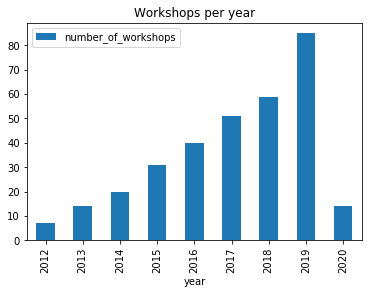

In [24]:
# How many workshops are there for each year?
workshops_per_year = workshops_df['year'].value_counts()
workshops_per_year.sort_index(ascending = True, inplace=True)
workshops_per_year.index.name = 'year'
print(workshops_per_year.index.dtype)
workshops_per_year.index = workshops_per_year.index.astype(int)
print(workshops_per_year.index.dtype)
print(workshops_per_year.index)
workshops_per_year = workshops_per_year.to_frame('number_of_workshops')
print(workshops_per_year)
workshops_per_year.plot(kind='bar', legend=True, title ="Workshops per year")

               number_of_workshops
workshop_type                     
SWC                            233
DC                              59
TTT                             15
LC                               7
                                 7


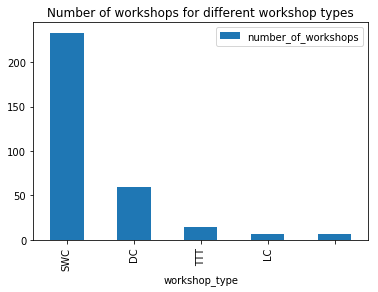

In [25]:
# How many SWC, DC, LC, TTT workshops were held so far?
workshops_per_type = workshops_df['workshop_type'].value_counts()
workshops_per_type.index.name = 'workshop_type'
workshops_per_type = workshops_per_type.to_frame('number_of_workshops')
print(workshops_per_type)
workshops_per_type.plot(kind='bar', legend=True, title ="Number of workshops for different workshop types")

workshop_type     DC  LC  SWC  TTT
year                              
2012.0         0   0   0    7    0
2013.0         0   0   0   14    0
2014.0         0   0   0   20    0
2015.0         0   2   1   24    4
2016.0         0   7   0   30    3
2017.0         0  12   2   33    4
2018.0         0  11   2   45    1
2019.0         6  25   1   50    3
2020.0         1   2   1   10    0


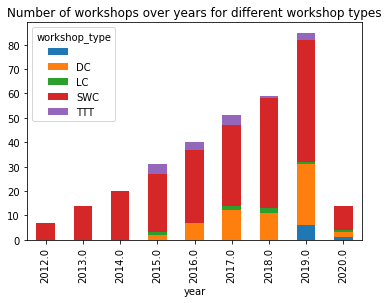

In [26]:
# How are numbers of different workshops (SWC, DC, LC, TTT) changing over years?
workshops_per_type_per_year = workshops_df.groupby(['workshop_type', 'year'])['workshop_type'].count().unstack('workshop_type').fillna(0).astype(dtype='int')
workshops_per_type_per_year.plot(kind='bar', stacked=True, title="Number of workshops over years for different workshop types")
print(workshops_per_type_per_year)

In [27]:
print(workshops_per_type_per_year.columns)

Index(['', 'DC', 'LC', 'SWC', 'TTT'], dtype='object', name='workshop_type')


ucl.ac.uk            34
ed.ac.uk             34
manchester.ac.uk     32
imperial.ac.uk       22
elixir-uk.org        19
leeds.ac.uk          18
ox.ac.uk             15
southampton.ac.uk    14
cam.ac.uk            11
swansea.ac.uk        10
st-andrews.ac.uk     10
bham.ac.uk           10
earlham.ac.uk         9
kcl.ac.uk             8
aber.ac.uk            5
anthro.ox.ac.uk       4
bristol.ac.uk         4
dundee.ac.uk          4
qmul.ac.uk            3
epcc.ed.ac.uk         3
tgac.ac.uk            3
shef.ac.uk            3
hw.ac.uk              2
qub.ac.uk             2
rhul.ac.uk            2
exeter.ac.uk          2
crick.ac.uk           2
surrey.ac.uk          2
york.ac.uk            2
gla.ac.uk             2
ncl.ac.uk             2
nottingham.ac.uk      2
nhm.ac.uk             2
warwick.ac.uk         1
bath.ac.uk            1
archer.ac.uk          1
bradford.ac.uk        1
lse.ac.uk             1
hud.ac.uk             1
cranfield.ac.uk       1
ukaea.uk              1
le.ac.uk        

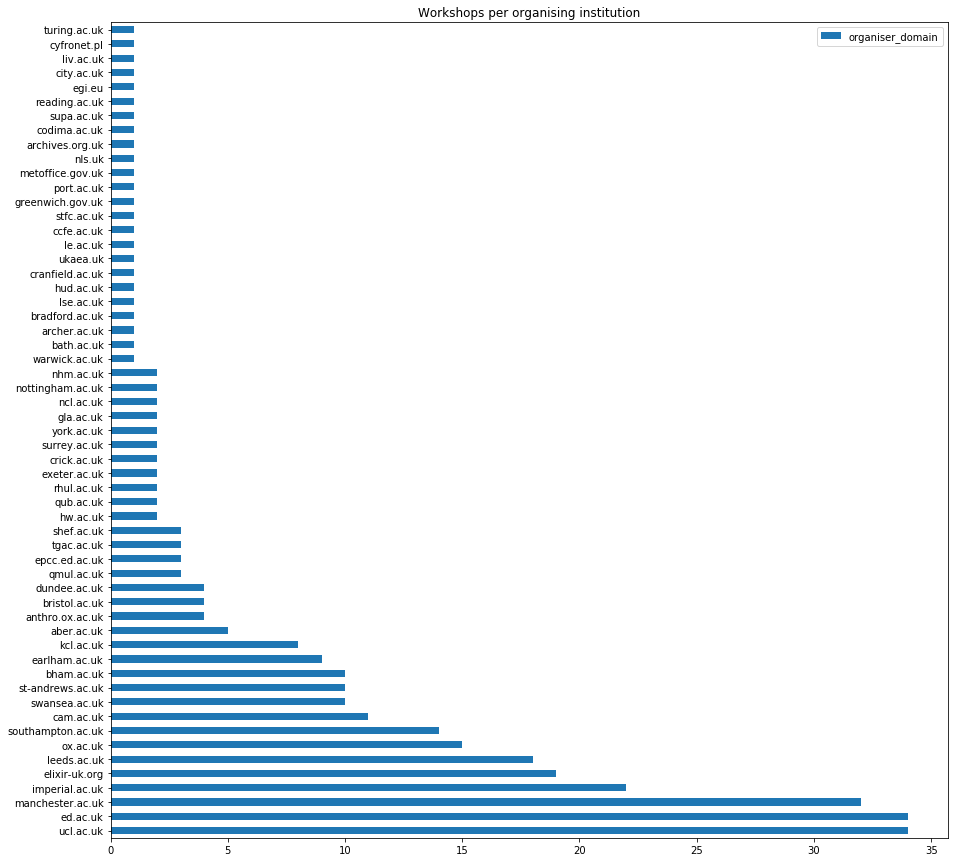

In [28]:
# How many workshops were held at each host institution?
workshops_per_host = workshops_df['organiser_domain'].value_counts()
print(workshops_per_host)
workshops_per_host.plot(kind='barh', legend=True, title ="Workshops per organising institution", figsize = (15,15))

year               2012.0  2013.0  2014.0  2015.0  2016.0  2017.0  2018.0  \
organiser_domain                                                            
bham.ac.uk              0       0       0       0       0       0       3   
cam.ac.uk               0       0       2       2       2       2       2   
earlham.ac.uk           0       0       0       0       1       3       0   
ed.ac.uk                1       1       1       1       5       0       9   
elixir-uk.org           0       0       0       0       0       0       4   
imperial.ac.uk          0       0       1       3       1       5       7   
kcl.ac.uk               0       0       0       0       0       0       3   
leeds.ac.uk             0       0       1       5       7       3       1   
manchester.ac.uk        0       1       3       5       2       5       7   
ox.ac.uk                1       1       0       3       2       2       3   
southampton.ac.uk       0       1       1       2       2       4       2   

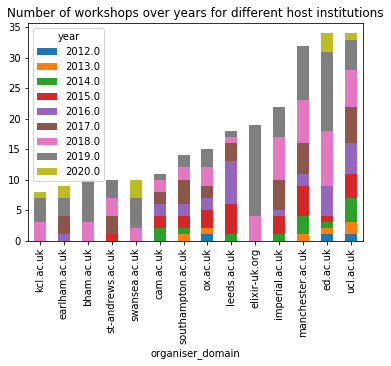

In [29]:
# How are numbers of workshops at different institutions changing over years? Only for hosts with over 5 workshops.
workshops_per_host_per_year = workshops_df.groupby(['organiser_domain', 'year'])['year'].count().unstack('year').fillna(0).astype(dtype='int')
# print(workshops_per_host_per_year.sum(axis = 1) > 5)
workshops_per_host_per_year = workshops_per_host_per_year[workshops_per_host_per_year.sum(axis = 1) >5]
print(workshops_per_host_per_year)
workshops_per_host_per_year = workshops_per_host_per_year.reindex(workshops_per_host_per_year.sum(axis = 1).sort_values().index)
# workshops_per_host_per_year.where(workshops_per_host_per_year.sum(axis = 1) > 5, inplace = True)
workshops_per_host_per_year.plot(kind='bar', stacked=True, title="Number of workshops over years for different host institutions")
print(workshops_per_host_per_year.index)
print(workshops_per_host_per_year.columns)

Workshops with no region: 
Northern Ireland             2
North East                   3
East Midlands                6
South West                   8
West Midlands               11
Wales                       14
Eastern                     23
Yorkshire and The Humber    24
North West                  32
South East                  40
Scotland                    52
London                      71
Name: region, dtype: int64
Total number of workshops: 286


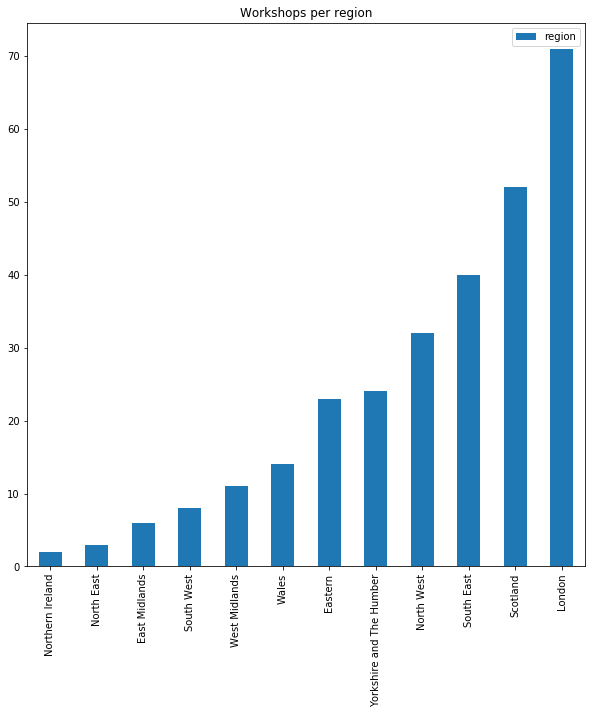

In [30]:
# How many workshops were held at each region?
print("Workshops with no region: ")
workshops_df[workshops_df['region']==""]

workshops_per_region = workshops_df['region'].value_counts().sort_values()
print(workshops_per_region)
total_no_workshops = workshops_per_region.sum()
print("Total number of workshops: " +str(total_no_workshops))
workshops_per_region.plot(kind='bar', legend=True, title ="Workshops per region", figsize = (10,10))

In [31]:
# Let's draw a clustered map of all workshop locations
# Add column 'description' which is used in popups in maps
workshops_df['popup'] = np.where(workshops_df["address"].empty, workshops_df["venue"],
                                                workshops_df["venue"] + ', ' + workshops_df["address"])
# Map only workshops that were actually held in the UK 
uk_only = workshops_df[workshops_df['country_code'] == 'GB']
# drop rows with NaN coordinates
uk_only = uk_only.dropna(subset=['longitude', 'latitude'])
workshop_locations_map = helper.generate_map_with_clustered_markers(uk_only)
workshop_locations_map

/Users/alex/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [32]:
# # Let's do a choropleth map of workshops per UK regions
# uk_regions = json.load(open(UK_REGIONS_FILE, encoding='utf-8-sig'))
# # Only use workshops that have a UK region
# workshops_with_uk_region = workshops_df.dropna(subset=['region'])
# workshop_regions_choropleth_map = helper.generate_choropleth_map(workshops_with_uk_region, uk_regions, "workshops")
# workshop_regions_choropleth_map

In [33]:
# uk_regions = json.load(open(UK_REGIONS_FILE, encoding='utf-8-sig'))
# workshops_with_uk_region = workshops_df.dropna(subset=['region'])
# entities_per_region_df = pd.DataFrame({'count': workshops_with_uk_region.groupby(['region']).size()}).reset_index()
# entities_per_region_df
# center = helper.get_center(workshops_with_uk_region)

# # Creates the threshold scale to be visualized in the map.
# scale_list = entities_per_region_df['count'].tolist()
# max_scale = max(scale_list)
# scale = int(max_scale / 5)
# threshold_scale = []
# for each in range(0, max_scale + 1, scale):
#     threshold_scale.append(each)
# map = folium.Map(
#         location=center,  # [54.00366, -2.547855],
#         zoom_start=6,
#         tiles='cartodbpositron')  # for a lighter map tiles='Mapbox Bright'
# print(entities_per_region_df)
# folium.Choropleth(
#          geo_data=uk_regions,
#          data=entities_per_region_df,
#          columns=['region', 'count'],
#          key_on='feature.properties.NAME',
#          fill_color='YlGn',
#          fill_opacity=0.7,
#          line_opacity=0.2,
#          legend_name='Number of workshops per UK regions',
#          threshold_scale=threshold_scale).add_to(map)
# folium.LayerControl().add_to(map)
# map

region
East Midlands                6
Eastern                     23
London                      71
North East                   3
North West                  32
Northern Ireland             2
Scotland                    52
South East                  40
South West                   8
Wales                       14
West Midlands               11
Yorkshire and The Humber    24
dtype: int64
workshop_type             N/A  DC  LC  SWC  TTT  total
region                                                
Northern Ireland            0   1   0    1    0      2
North East                  1   0   0    2    0      3
East Midlands               0   0   0    6    0      6
South West                  0   0   0    7    1      8
West Midlands               0   0   0   11    0     11
Wales                       2   2   0   10    0     14
Eastern                     0  12   1    9    1     23
Yorkshire and The Humber    0   4   1   17    2     24
North West                  1   6   1   21    3     32
Sou

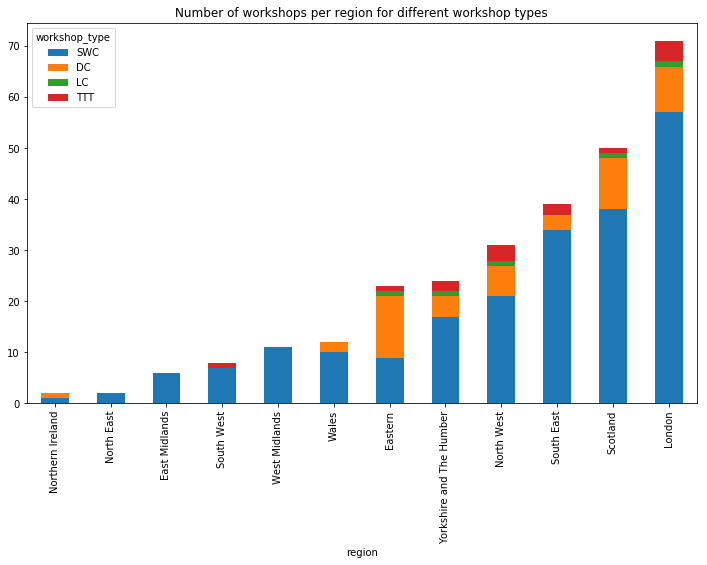

In [45]:
# How are numbers of different workshop types (SWC, DC, LC, TTT) looking per regions?
workshops_per_type_per_region = workshops_df.groupby(['workshop_type', 'region'])['workshop_type'].count().unstack('workshop_type').fillna(0).astype(dtype='int')
print(workshops_per_type_per_region.sum(axis = 1, skipna = True))
workshops_per_type_per_region['total'] = workshops_per_type_per_region.sum(axis = 1, skipna = True)
workshops_per_type_per_region = workshops_per_type_per_region.sort_values(axis = 0, by=['total'])
# Rename '' column as 'N/A' as these are workshops we do not have type for, mainly 'Circuits'
workshops_per_type_per_region.rename(columns={'' : 'N/A'}, inplace=True)
print(workshops_per_type_per_region)
print(workshops_per_type_per_region.columns)
workshops_per_type_per_region[WORKSHOP_TYPES].plot(kind='bar', stacked=True, title="Number of workshops per region for different workshop types", figsize = (12,7))

In [ ]:
# Add R&D expenditure per region and let's plot that alongside workshops per region to see how they match
R_and_D_expenditure = pd.read_csv(CURRENT_DIR +"/lib/R_and_D_expenditure_2017.csv", encoding = "utf-8")
R_and_D_expenditure_mapping = dict(R_and_D_expenditure[['Region','% of total R&D expenditure']].values)
R_and_D_expenditure_vs_workshops_per_region = pd.DataFrame()
R_and_D_expenditure_vs_workshops_per_region['region'] = workshops_per_region.index
R_and_D_expenditure_vs_workshops_per_region['workshop_count'] = workshops_per_region.index
R_and_D_expenditure_vs_workshops_per_region['workshop_count'] = R_and_D_expenditure_vs_workshops_per_region['workshop_count'].map(workshops_per_region)
R_and_D_expenditure_vs_workshops_per_region['R_and_D_expenditure_%'] = R_and_D_expenditure_vs_workshops_per_region['region'].map(R_and_D_expenditure_mapping)
total_no_workshops = workshops_per_region.sum()
R_and_D_expenditure_vs_workshops_per_region['workshop_count_%'] = (R_and_D_expenditure_vs_workshops_per_region['workshop_count']/total_no_workshops)*100
R_and_D_expenditure_vs_workshops_per_region.index = R_and_D_expenditure_vs_workshops_per_region['region']
print("Total number of workshops: " +str(total_no_workshops))
print(R_and_D_expenditure_vs_workshops_per_region)
R_and_D_expenditure_vs_workshops_per_region[['workshop_count_%', 'R_and_D_expenditure_%']].plot(kind='bar', legend=True, title ="Workshops per region vs R&D HE expenditure", figsize = (12,7))

In [ ]:
R_and_D_expenditure_vs_workshops_per_region

In [ ]:
# Let's see similar comparison to R&D expenditure but
# using total research income per region alongside workshops per region
research_income = pd.read_csv(CURRENT_DIR +"/lib/HESA_UK_research_income_combined.csv", encoding = "utf-8")
research_income = research_income[['total_%', 'region']]
research_income_per_region = research_income.groupby(['region'])['total_%'].sum().to_frame()
research_income_per_region.rename(columns={'total_%': 'research_income_%'}, inplace=True)
# research_income_per_region['region'] = research_income_per_region.index
# Merge 2 frames, both having 'region' as index
research_income_per_region = (research_income_per_region.merge
                                               (R_and_D_expenditure_vs_workshops_per_region, left_index=True, right_index=True)
                                              .reindex(columns=['workshop_count_%', 'R_and_D_expenditure_%', 'research_income_%']))
print(research_income_per_region)
research_income_per_region[['workshop_count_%', 'R_and_D_expenditure_%', 'research_income_%']].plot(kind='bar', legend=True, title ="Workshops per region vs R&D HE expenditure vs Research Income", figsize = (12,7))

In [ ]:
research_income_per_region

In [ ]:
# How about workshop domains?
# All workshop domains
domains = pd.read_csv(CURRENT_DIR + "/lib/all_domains.csv", encoding = "utf-8")

workshops_with_domains = workshops_df[~workshops_df["workshop_request_domains"].isnull()]
print(workshops_with_domains["workshop_request_domains"])

domains["count"] = domains["name"].apply(lambda domain: workshops_with_domains["workshop_request_domains"].apply(lambda x: domain in x).sum())
domains.index = domains["name"]
domains = domains.sort_values(by=['count'])

total_workshops = workshops_with_domains["workshop_request_domains"].count()
print("\nOccurances of domains for " + str(total_workshops) + " workshops:\n")
print(domains)

domains.plot(kind='barh', title="Workshop domains (" + str(total_workshops) + " workshops)")

In [ ]:
# How many learners attended workshops over years?
attendance_per_year = workshops_df.groupby(['year'])["attendance"].sum().fillna(0).astype("int")
print(attendance_per_year)
attendance_per_year.plot(kind='bar', legend=True, title ="Number of learners for all workshop types over years")

In [ ]:
# How many learners attended workshops over years (with adjustments for missing attendance data with average attendance)?

# Disregard TTT workshops as they have attendance capped at 20 most of the times
average_attendance = round(workshops_df[workshops_df["workshop_type"] != "TTT"]["attendance"].mean())
print("Average workshop attendance: " + str(average_attendance) + "\n")
# Adjusted attendance over year data and graph
workshops_df["attendance"].fillna(average_attendance, inplace=True)
attendance_per_year = workshops_df.groupby(['year'])["attendance"].sum().astype("int")
print(attendance_per_year)
attendance_per_year.plot(kind='bar', legend=True, title ="Adjusted number of learners for all workshop types over years")

In [ ]:
# Total attendance for different workshop types (with missing data adjusted with average attendance)
attendance_per_type = workshops_df.groupby(['workshop_type'])['attendance'].sum().astype("int")
print(attendance_per_type)
attendance_per_type.plot(kind="bar", title="Total attendance per workshop type")

In [ ]:
# How many learners attended each of (SWC, DC, LC, TTT) workshops over years (missing data adjusted by average attendance)?
attendance_per_type_per_year = workshops_df.groupby(['workshop_type', 'year'])['attendance'].sum().unstack("workshop_type").fillna(0).astype("int")
print(attendance_per_type_per_year)
attendance_per_type_per_year.plot(kind='bar', stacked=True, title="Attendance at different workshop types over years")


In [ ]:
# Attendance just for SWC workshops over years
# Can be done similarly for DC, LC, TTT workshops, this is just an example
attendance_per_type_per_year["SWC"].plot(kind='bar', title="Attendance at SWC workshops")

In [ ]:
# How are workshops spread over UK regions? - plot workshops over UK regions
workshops_per_UK_region = workshops_df['region'].value_counts()
workshops_per_UK_region.index.name = 'region'
workshops_per_UK_region = workshops_per_UK_region.to_frame('number_of_workshops')
print(workshops_per_UK_region)
workshops_per_UK_region.plot(kind='bar', legend=True, title ="Workshops per UK region")

In [ ]:
# Save all analyses into an Excel spreadsheet
ANALYSES_DIR = "data/analyses/"
if not os.path.exists(ANALYSES_DIR):
    os.makedirs(ANALYSES_DIR)

workshops_file_name = os.path.basename(workshops_file)
workshops_file_name_without_extension = re.sub('\.csv$', '', workshops_file_name.strip())
workshop_analyses_excel_file = ANALYSES_DIR + "analysed_" + workshops_file_name_without_extension + '_from_ipynb.xlsx'

excel_writer = pd.ExcelWriter(workshop_analyses_excel_file, engine='xlsxwriter')

# Write README
workbook = excel_writer.book
worksheet = workbook.add_worksheet('README')
readme_text = "Analyses done using code from 'outcome2.1' branch: " + \
"https://github.com/softwaresaved/carpentry-workshops-instructors-extractor/tree/outcome2.1 and" + \
"saved to file " + workshop_analyses_excel_file + " which was then uploaded to this sheet in Google drive." 
worksheet.write(0, 0, readme_text)
readme_text = "Raw files and analyses files available from the following tag: " + \
"https://github.com/softwaresaved/carpentry-workshops-instructors-extractor/tree/ad-board-march-2020 " + \
"Raw files and analyses files available from the following tag: " +\
"https://github.com/softwaresaved/carpentry-workshops-instructors-extractor/tree/ad-board-march-2020"
worksheet.write(2, 0, readme_text)

# Write the processed data
workshops_df.to_excel(excel_writer, sheet_name=os.path.splitext(workshops_file_name)[0][:31], index=False)

# Write UK academic insitutions table we used for lookup
uk_academic_institutions.to_excel(excel_writer, sheet_name='uk_academic_institutions', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['uk_academic_institutions']

# Workshops per year
workshops_per_year.to_excel(excel_writer, sheet_name='workshops_per_year', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_per_year']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['workshops_per_year', 1, 0, len(workshops_per_year.index), 0],
        'values': ['workshops_per_year', 1, 1, len(workshops_per_year.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Year'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of workshops per year'})
worksheet.insert_chart('I2', chart)

# Workshops per type   
workshops_per_type.to_excel(excel_writer, sheet_name='workshops_per_type', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_per_type']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['workshops_per_type', 1, 0, len(workshops_per_type.index), 0],
        'values': ['workshops_per_type', 1, 1, len(workshops_per_type.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Workshop type'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of workshops of different types'})
worksheet.insert_chart('I2', chart)
    
# Workshops per type per year
workshops_per_type_per_year.to_excel(excel_writer, sheet_name='workshops_per_type_per_year', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_per_type_per_year']
chart = workbook.add_chart({'type': 'column', 'subtype': 'stacked'})
for i in range(1, len(workshops_per_type_per_year.columns) + 1):
    chart.add_series({
            'name': ['workshops_per_type_per_year', 0, i],
            'categories': ['workshops_per_type_per_year', i, 0, len(workshops_per_type_per_year.index), 0],
            'values': ['workshops_per_type_per_year', 1, i, len(workshops_per_type_per_year.index), i],
            'gap': 2,
        })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_x_axis({'name': 'Year'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of workshops of different types over years'})
worksheet.insert_chart('B20', chart)

# Workshops per host
workshops_per_host.to_excel(excel_writer, sheet_name='workshops_per_host', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_per_host']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['workshops_per_host', 1, 0, len(workshops_per_host.index), 0],
        'values': ['workshops_per_host', 1, 1, len(workshops_per_host.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Host institution'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of workshops per host'})
worksheet.insert_chart('I2', chart)

# Workshops per host per year
workshops_per_host_per_year.to_excel(excel_writer, sheet_name='workshops_per_host_per_year', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_per_host_per_year']
chart = workbook.add_chart({'type': 'column', 'subtype': 'stacked'})
for i in range(1, len(workshops_per_host_per_year.columns) + 1):
    chart.add_series({
            'name': ['workshops_per_type_per_year', 0, i],
            'categories': ['workshops_per_host_per_year', i, 0, len(workshops_per_host_per_year.index), 0],
            'values': ['workshops_per_host_per_year', 1, i, len(workshops_per_host_per_year.index), i],
            'gap': 2,
        })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_x_axis({'name': 'Year'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of workshops at different hosts over years'})
worksheet.insert_chart('B20', chart)

# Workshops per region
workshops_per_region.to_excel(excel_writer, sheet_name='workshops_per_region', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_per_region']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['workshops_per_region', 1, 0, len(workshops_per_region.index), 0],
        'values': ['workshops_per_region', 1, 1, len(workshops_per_region.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Host institution'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of workshops per region'})
worksheet.insert_chart('I2', chart)

# Workshops per type per region
workshops_per_type_per_region.to_excel(excel_writer, sheet_name='workshops_per_type_per_region', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_per_type_per_region']
chart = workbook.add_chart({'type': 'column', 'subtype': 'stacked'})
for i in range(1, len(workshops_per_type_per_region.columns) + 1):
    chart.add_series({
            'name': ['workshops_per_type_per_region', 0, i],
            'categories': ['workshops_per_type_per_region', i, 0, len(workshops_per_type_per_region[WORKSHOP_TYPES].index), 0],
            'values': ['workshops_per_type_per_region', 1, i, len(workshops_per_type_per_region[WORKSHOP_TYPES].index), i],
            'gap': 2,
        })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_x_axis({'name': 'Region'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of workshops of different type per region'})
worksheet.insert_chart('B20', chart)

# Write R&D expenditure table we used for lookup
R_and_D_expenditure.to_excel(excel_writer, sheet_name='R_and_D_expenditure', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['R_and_D_expenditure']

# R&D expenditure vs workshop numbers per region
R_and_D_expenditure_vs_workshops_per_region.to_excel(excel_writer, sheet_name='R&D_expenditure_vs_workshops', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['R&D_expenditure_vs_workshops']
chart = workbook.add_chart({'type': 'column'})
# Some alternative colors for the 2 bars on the chart
colors = ['#ffa500', '#377EB8']#, '#4DAF4A', '#984EA3', '#FF7F00']
# Column numbers we are plotting
columns_to_plot = [list(R_and_D_expenditure_vs_workshops_per_region.columns).index("R_and_D_expenditure_%"),
                   list(R_and_D_expenditure_vs_workshops_per_region.columns).index("workshop_count_%")]
# Add series from the dataframe data that we want to plot.
# [sheetname, first_row, first_col, last_row, last_col]
for i in range(0, len(columns_to_plot)):
    chart.add_series({
        'name':       ['R&D_expenditure_vs_workshops', 0, columns_to_plot[i] + 1],
        'categories': ['R&D_expenditure_vs_workshops', 1, 0, len(workshops_per_region.index), 0],
        'values':     ['R&D_expenditure_vs_workshops', 1, columns_to_plot[i] + 1, len(workshops_per_region.index), columns_to_plot[i] + 1],
        'fill':       {'color':  colors[i]},
        'overlap':    -10,
    })
chart.set_x_axis({'name': 'Region'})
chart.set_y_axis({'name': '%', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'R&D expenditure and workshop numbers per region'})
worksheet.insert_chart('I2', chart)

# R&D expenditure vs workshop numbers vs total research income per region
research_income_per_region.to_excel(excel_writer, sheet_name='R&D_exp_vs_income_vs_workshops', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['R&D_exp_vs_income_vs_workshops']
chart = workbook.add_chart({'type': 'column'})
# Some alternative colors for the 3 bars on the chart
colors = ['#ffa500', '#377EB8', '#4DAF4A']#, '#984EA3', '#FF7F00']
# research_income_per_region[['workshop_count_%', 'R_and_D_expenditure_%', 'research_income_%']].plot(kind='bar', legend=True, title ="Workshops per region vs R&D HE expenditure vs Research Income", figsize = (12,7))
# Column numbers we are plotting
columns_to_plot = [list(research_income_per_region.columns).index("R_and_D_expenditure_%"),
                   list(research_income_per_region.columns).index('research_income_%'),
                    list(research_income_per_region.columns).index('workshop_count_%')]
# Add series from the dataframe data that we want to plot.
# [sheetname, first_row, first_col, last_row, last_col]
for i in range(0, len(columns_to_plot)):
    chart.add_series({
        'name':       ['R&D_exp_vs_income_vs_workshops', 0, columns_to_plot[i] + 1],
        'categories': ['R&D_exp_vs_income_vs_workshops', 1, 0, len(research_income_per_region.index), 0],
        'values':     ['R&D_exp_vs_income_vs_workshops', 1, columns_to_plot[i] + 1, len(research_income_per_region.index), columns_to_plot[i] + 1],
        'fill':       {'color':  colors[i]},
        'overlap':    -10,
    })
chart.set_x_axis({'name': 'Region'})
chart.set_y_axis({'name': '%', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'R&D expenditure, research income and workshop numbers per region'})
worksheet.insert_chart('I2', chart)

# Workshop domains
domains['count'].to_excel(excel_writer, sheet_name='workshops_domains', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_domains']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['workshops_domains', 1, 0, len(domains.index), 0],
        'values': ['workshops_domains', 1, 1, len(domains.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Domains'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of workshops per domain' + ' (based on ' + 
                 str( workshops_with_domains['workshop_status'].count()) + ' workshops)'})
worksheet.insert_chart('I2', chart)

# # Workshop attendance per year
# attendance_per_year.to_excel(excel_writer, sheet_name='attendance_per_year', index=True)
# workbook = excel_writer.book
# worksheet = excel_writer.sheets['attendance_per_year']
# chart = workbook.add_chart({'type': 'column'})
# chart.add_series({
#         'categories': ['attendance_per_year', 1, 0, len(attendance_per_year.index), 0],
#         'values': ['attendance_per_year', 1, 1, len(attendance_per_year.index), 1],
#         'gap': 2,
#     })
# chart.set_y_axis({'major_gridlines': {'visible': False}})
# chart.set_legend({'position': 'none'})
# chart.set_x_axis({'name': 'Year'})
# chart.set_y_axis({'name': 'Number of attendees', 'major_gridlines': {'visible': False}})
# chart.set_title({'name': 'Number of attendees per year (with estimates for missing data)'})
# worksheet.insert_chart('I2', chart)

# # Workshop attendance per workshop type
# attendance_per_type.to_excel(excel_writer, sheet_name='attendance_per_type', index=True)
# workbook = excel_writer.book
# worksheet = excel_writer.sheets['attendance_per_type']
# chart = workbook.add_chart({'type': 'column'})
# chart.add_series({
#         'categories': ['attendance_per_type', 1, 0, len(attendance_per_type.index), 0],
#         'values': ['attendance_per_type', 1, 1, len(attendance_per_type.index), 1],
#         'gap': 2,
#     })
# chart.set_y_axis({'major_gridlines': {'visible': False}})
# chart.set_legend({'position': 'none'})
# chart.set_x_axis({'name': 'Workshop type'})
# chart.set_y_axis({'name': 'Number of attendees', 'major_gridlines': {'visible': False}})
# chart.set_title({'name': 'Number of attendees per workshop type (with estimates for missing data)'})
# worksheet.insert_chart('I2', chart)

# # Workshop attendance per workshop type per year
# attendance_per_type_per_year.to_excel(excel_writer, sheet_name='attendance_per_type_per_year', index=True)
# workbook = excel_writer.book
# worksheet = excel_writer.sheets['attendance_per_type_per_year']
# chart = workbook.add_chart({'type': 'column', 'subtype': 'stacked'})
# for i in range(1, len(attendance_per_type_per_year.columns) + 1):
#     chart.add_series({
#             'name': ['attendance_per_type_per_year', 0, i],
#             'categories': ['attendance_per_type_per_year', i, 0, len(attendance_per_type_per_year.index), 0],
#             'values': ['attendance_per_type_per_year', 1, i, len(attendance_per_type_per_year.index), i],
#             'gap': 2,
#         })
# chart.set_y_axis({'major_gridlines': {'visible': False}})
# chart.set_x_axis({'name': 'Year'})
# chart.set_y_axis({'name': 'Attendance', 'major_gridlines': {'visible': False}})
# chart.set_title({'name': 'Attendance at workshops of different types over years (with estimates for missing data)'})
# worksheet.insert_chart('B20', chart)

excel_writer.save()
print("Saved workshop analyses in " + workshop_analyses_excel_file)

# Save maps to HTML files
# map_file = MAPS_DIR + '/choropleth_map_UK_regions_' + workshops_file_name_without_extension + '.html'
# workshop_regions_choropleth_map.save(map_file)
# print('Choropleth map of workshops over UK regions saved to HTML file ' + map_file + '\n')
# map_file = MAPS_DIR + '/map_clustered_markers_' + workshops_file_name_without_extension + '.html'
# workshop_locations_map.save(map_file)
# print('Map of clustered workshop locations saved to HTML file ' + map_file + '\n')